# Keyword network
In this notebok, we'll use the papers' keywords and their citation connections to build a graph.

In [1]:
import networkx as nx
import jsonlines
from collections import defaultdict, Counter
from venny4py.venny4py import venny4py
import pandas as pd
import seaborn as sns
from random import sample
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline
from ast import literal_eval
import sys
sys.path.append('../citation_network/')
from utils import map_classes_to_jsonl

## Read in data

In [2]:
graph = nx.read_graphml('../data/citation_network/core_collection_destol_or_anhydro_FILTERED_classified_network_06Jan2023_MANUALLY_VERIFIED.graphml')

In [3]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_FILTERED_MAIN_ONLY_with_ref_abstracts_05Jan2023.jsonl') as reader:
    data = []
    for obj in reader:
        data.append(obj)

In [4]:
# Map classes
data_with_classes = map_classes_to_jsonl(graph, data, False, 'UID')

In [5]:
# Index papers by WOS
paper_idx = {doc['UID']: [k.lower() for k in doc['paper_keywords']] for doc in data}

## Get general keyword frequency metrics

### Number of papers with keywords

In [6]:
papers_with_keys = sum([1 for doc in data if len(doc['paper_keywords']) > 0])
print(f'{papers_with_keys} of {len(data)} total papers have at least one keyword.')

4712 of 5963 total papers have at least one keyword.


### Keywords per paper

The max number of keywords in one paper is 23


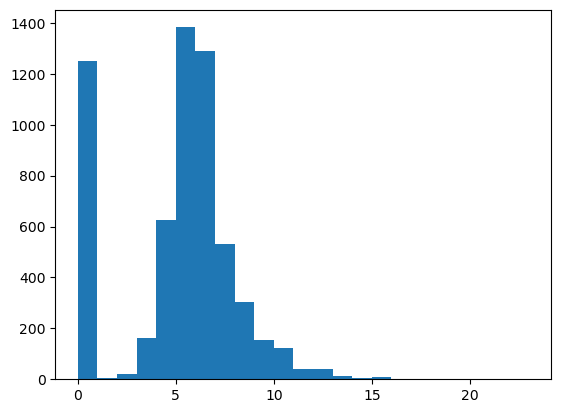

In [7]:
per_paper = [len(doc['paper_keywords']) for doc in data]
print(f'The max number of keywords in one paper is {max(per_paper)}')
_ = plt.hist(per_paper, bins=23)

### Top ten keywords and overall numbers

In [8]:
keys_by_system = defaultdict(list)
for node, attrs in graph.nodes(data=True):
    keys_by_system[attrs['study_system']].extend(paper_idx[node])

In [9]:
for king, words in keys_by_system.items():
    print(f'\nThere are {len(set(words))} unique keywords for kingdom {king}.')
    counted = Counter(words)
    top_ten = '\nWord --- Count\n' + '\n'.join([f'{c[0]} --- {c[1]}' for c in counted.most_common(10)])
    print(f'The top ten  most common words are: {top_ten}')


There are 7789 unique keywords for kingdom Plant.
The top ten  most common words are: 
Word --- Count
desiccation tolerance --- 597
desiccation --- 334
abscisic acid --- 174
germination --- 149
photosynthesis --- 128
cryopreservation --- 125
dehydration --- 114
drought --- 113
chlorophyll fluorescence --- 99
seed development --- 98

There are 2986 unique keywords for kingdom Animal.
The top ten  most common words are: 
Word --- Count
desiccation --- 167
anhydrobiosis --- 165
desiccation tolerance --- 86
trehalose --- 65
cold tolerance --- 44
desiccation resistance --- 44
tardigrada --- 42
dehydration --- 36
climate change --- 34
water balance --- 34

There are 1644 unique keywords for kingdom Microbe.
The top ten  most common words are: 
Word --- Count
desiccation --- 76
cyanobacteria --- 58
desiccation tolerance --- 54
trehalose --- 29
anhydrobiosis --- 24
biofilm --- 18
osmotic stress --- 16
survival --- 14
photosynthesis --- 14
nostoc flagelliforme --- 13

There are 449 unique keyw

### Distribution of keyword frequency

In [10]:
for_df = {'system':[], 'keyword':[], 'freq': []}
for sys, keys in keys_by_system.items():
    for key, num in Counter(keys).items():
        for_df['system'].append(sys)
        for_df['keyword'].append(key)
        for_df['freq'].append(num)
keyword_freqs_longform = pd.DataFrame(for_df)
keyword_freqs_longform.head()

,system,keyword,freq
0,Plant,abscisic acid,174
1,Plant,cynanchum komarovii,1
2,Plant,mineral,1
3,Plant,dehydrin,42
4,Plant,drying rate,14


/mnt/home/lotrecks/anaconda3/envs/graphs/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


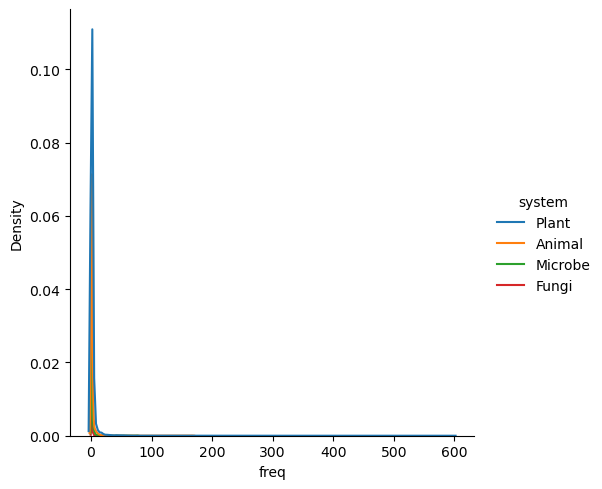

In [11]:
sns.displot(data=keyword_freqs_longform, x='freq', hue='system', kind='kde')

### Wordcloud

In [12]:
from collections import Counter
all_keywords = Counter([key.lower() for doc in data for key in doc['paper_keywords']])

In [13]:
from wordcloud import WordCloud, STOPWORDS

In [14]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate_from_frequencies(all_keywords)

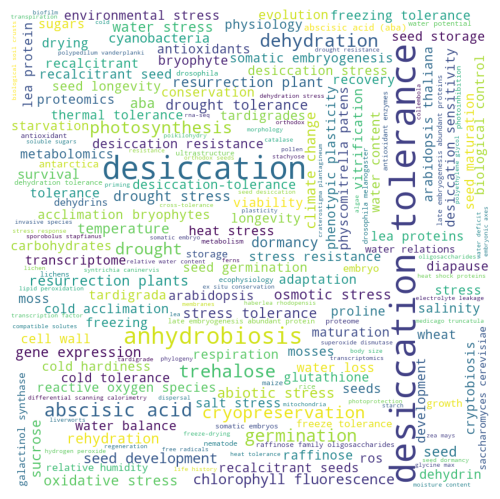

In [15]:
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('../data/citation_network/figures/all_keywords_word_cloud.png', format='png', bbox_inches='tight', dpi=600)

### Venn diagram of keywords by system

In [16]:
sets = {sys: set(keys) for sys, keys in keys_by_system.items()}

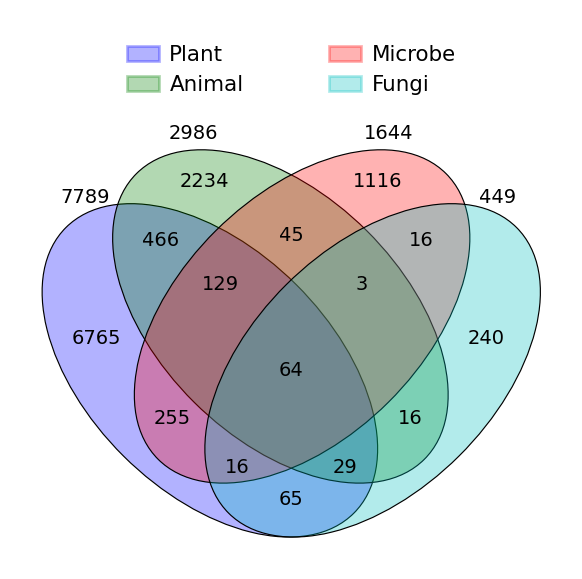

In [17]:
venny4py(sets=sets, out='../data/citation_network/figures/')

### Proportion of kingdom keywords unique to the kingdom

In [18]:
for sys, keys in keys_by_system.items():
    sys_set = set(keys)
    other_sys = set([word for k, v in keys_by_system.items() for word in v if k != sys])
    unique = sys_set - other_sys
    prop_unique = (len(unique)/len(sys_set))*100
    print(f'{prop_unique:.2f}% of {sys} keywords are unique to {sys}.')
    print(f'Examples of unique keywords: {", ".join(sample(list(unique), 5))}')

86.85% of Plant keywords are unique to Plant.
Examples of unique keywords: dehardening, stepwise origin, vacuums, photorespiration, olive
74.82% of Animal keywords are unique to Animal.
Examples of unique keywords: metabarcoding, heat-shock response, sedimentation, state predictions, igf-1
67.88% of Microbe keywords are unique to Microbe.
Examples of unique keywords: cellular water, cyclopropane fatty acid, general stress protein (gsib), pseudomonas aeruginosa, sporophyll
53.45% of Fungi keywords are unique to Fungi.
Examples of unique keywords: culture age, bioinsecticide, fungal propagule, high throughput growth kinetics, the taklimakan desert


### Top keywords shared by groups

In [19]:
with open('../data/citation_network/figures/Intersections_4.txt') as myf:
    intersections = myf.readlines()

In [20]:
intersection_lists = {}
for line in intersections:
    group = line.split(':')[0]
    if ' and ' in group:
        key = tuple(group.split(' and '))
    else:
        key = group
    to_eval_start = len(line.split(',')[0])+2
    to_eval = line[to_eval_start:].strip()
    terms = literal_eval(to_eval)
    intersection_lists[key] = terms

In [21]:
intersection_lens = {k: len(v) for k, v in intersection_lists.items()}
intersection_lens

{'Plant': 6765,
 'Animal': 2234,
 'Microbe': 1116,
 'Fungi': 240,
 ('Plant', 'Animal'): 466,
 ('Plant', 'Microbe'): 255,
 ('Plant', 'Fungi'): 65,
 ('Animal', 'Microbe'): 45,
 ('Animal', 'Fungi'): 16,
 ('Microbe', 'Fungi'): 16,
 ('Plant', 'Animal', 'Microbe'): 129,
 ('Plant', 'Animal', 'Fungi'): 29,
 ('Plant', 'Microbe', 'Fungi'): 16,
 ('Animal', 'Microbe', 'Fungi'): 3,
 ('Plant', 'Animal', 'Microbe', 'Fungi'): 64}

In [22]:
print(f'Keywords shared by all four kingdoms:\n{intersection_lists[("Plant", "Animal", "Microbe", "Fungi")]}')

Keywords shared by all four kingdoms:
['abiotic stress', 'anhydrobiosis', 'antarctic', 'antioxidants', 'biocontrol', 'biological control', 'bryophytes', 'climate change', 'compatible solutes', 'dehydration', 'desiccation', 'desiccation resistance', 'desiccation stress', 'desiccation tolerance', 'drought tolerance', 'environmental stresses', 'ethanol', 'flow cytometry', 'freezing', 'fungi', 'gene expression', 'glutathione', 'glycerol', 'glycogen', 'growth', 'heat shock', 'intrinsically disordered proteins', 'lea protein', 'lea proteins', 'lipids', 'membrane permeability', 'metabolism', 'morphology', 'osmolytes', 'osmotic stress', 'oxidative stress', 'polymorphism', 'polyols', 'reactive oxygen species', 'rehydration', 'relative humidity', 'ros', 'saccharomyces cerevisiae', 'salinity', 'salt stress', 'starvation', 'storage stability', 'stress', 'stress resistance', 'stress response', 'stress tolerance', 'sucrose', 'sugars', 'superoxide dismutase', 'temperature', 'temperature tolerance', '

What papers from the Plant/Animal papers have saccharomyces cerevisisae as a keyword?

In [23]:
yeast_abstracts = {}
for doc in data_with_classes:
    for keyword in doc['paper_keywords']:
        if (keyword.lower() == 'saccharomyces cerevisiae') and (doc['study_system'] in ['Plant', 'Animal']):
            yeast_abstracts[doc['UID']] = doc['abstract']
yeast_abstracts

{'WOS:000484877300008': 'A healthy gut microbiota generally improves the performance of its insect host. Although the effects can be specific to the species composition of the microbial community, the role of gut microbiota in determining water balance has not been well explored. We used axenic and gnotobiotic (reared with a known microbiota) Drosophila melanogaster to test three hypotheses about the effects of gut yeasts on the water balance of adult flies: 1) that gut yeasts would improve desiccation survival in adult flies; 2) that larval yeasts would improve adult desiccation survival; 3) that the effects would be species-specific, such that yeasts closely associated with D. melanogaster in nature are more likely to be beneficial than those rarely found in association with D. melanogaster. We used Saccharomyces cerevisiae (often used in Drosophila cultures, but rarely associated with D. melanogaster in nature), Lachancea kluyveri (associated with some species of Drosophila, but not

In [24]:
print(f'Keywords shared by Animal, Microbe and Fungi:\n{intersection_lists[("Animal", "Microbe", "Fungi")]}')

Keywords shared by Animal, Microbe and Fungi:
['desiccation survival', 'pathogenicity', 'stress adaptation']


In [25]:
print(f'Keywords shared by Plant, Animal, and Microbe:\n{intersection_lists[("Plant", "Animal", "Microbe")]}')

Keywords shared by Plant, Animal, and Microbe:
['aba', 'adaptation', 'aerial exposure', 'antarctica', 'antioxidant', 'antioxidant enzymes', 'arctic', 'astrobiology', 'bacteria', 'betaine', 'biodiversity', 'carbohydrates', 'cold', 'cold storage', 'cold tolerance', 'colonization', 'community ecology', 'community structure', 'comparative genomics', 'compatible solute', 'conservation', 'cryopreservation', 'cryptobiosis', 'cyst', 'desert', 'differential gene expression', 'disturbance', 'dna damage', 'dna repair', 'dormancy', 'drosophila melanogaster', 'drought', 'drought resistance', 'ecology', 'energy', 'entomopathogenic nematodes', 'environmental stress', 'evolution', 'extreme environment', 'extreme environments', 'extremophile', 'extremophiles', 'fatty acids', 'fitness', 'fluorescence', 'freeze-drying', 'freezing tolerance', 'gamma radiation', 'genome', 'global change', 'heat', 'heat resistance', 'heat stress', 'heat tolerance', 'heat wave', 'heat-shock protein', 'hibernation', 'high tem

What Animal and Microbe papers have Zea mays as a keyword?

In [26]:
zea_abstracts = {}
for doc in data_with_classes:
    for keyword in doc['paper_keywords']:
        if (keyword.lower() == 'zea mays') and (doc['study_system'] in ['Microbe', 'Animal']):
            zea_abstracts[doc['UID']] = doc['abstract']
zea_abstracts

{'WOS:000358899400035': "Five desiccation-tolerant rhizobacteria (Brevibacterium frigoritolerans-LPS1B, Bacillus subtilis-CHFT15, B. subtilis-CHFT12, B. subtilis-CH13, and Pseudomonas stutzeri-CHP413A) isolated from Pakistan's Cholistan desert were characterized on the basis of morphological, biochemical, and 16S rDNA ribotyping. The desiccation tolerance was checked at various relative humidity levels (5, 23, and 100%) for a period of 1-40 days. Heavy metal and antibiotic resistance, auxin, cytokine, siderophore, hydrogen cyanide production, and phosphate solubilization of select bacterial isolates was also investigated. Pot experiments with corn in sandy and pure soil were also carried out to check the plant growth-promoting potential of select strains after 90 days of growth. After harvest, various growth parameters like seed germination, root and shoot length, number of leaves, dry weight per gram fresh weight, and chlorophyll contents were determined. The inoculation of P. stutzer

In [27]:
print(f'Keywords shared by Plant, Fungi, and Microbe:\n{intersection_lists[("Plant", "Microbe", "Fungi")]}')

Keywords shared by Plant, Fungi, and Microbe:
['abscisic acid', 'carotenoids', 'catalase', 'chlorophyll fluorescence', 'dehydration stress', 'dehydrin', 'desiccation-tolerance', 'differential display', 'drying', 'germination', 'invasion', 'lichens', 'phenotype', 'photoinhibition', 'polyethylene glycol', 'salt tolerance']


### Word cloud of keywords shared by all kingdoms

In [38]:
to_keep = [keyword.lower() for keyword in intersection_lists[("Plant", "Animal", "Microbe", "Fungi")]]
shared_keys = []
for doc in data:
    for keyword in doc['paper_keywords']:
        if keyword.lower() in to_keep:
            shared_keys.append(keyword.lower())

In [39]:
len(set(shared_keys))

64

In [40]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate_from_frequencies(Counter(shared_keys))

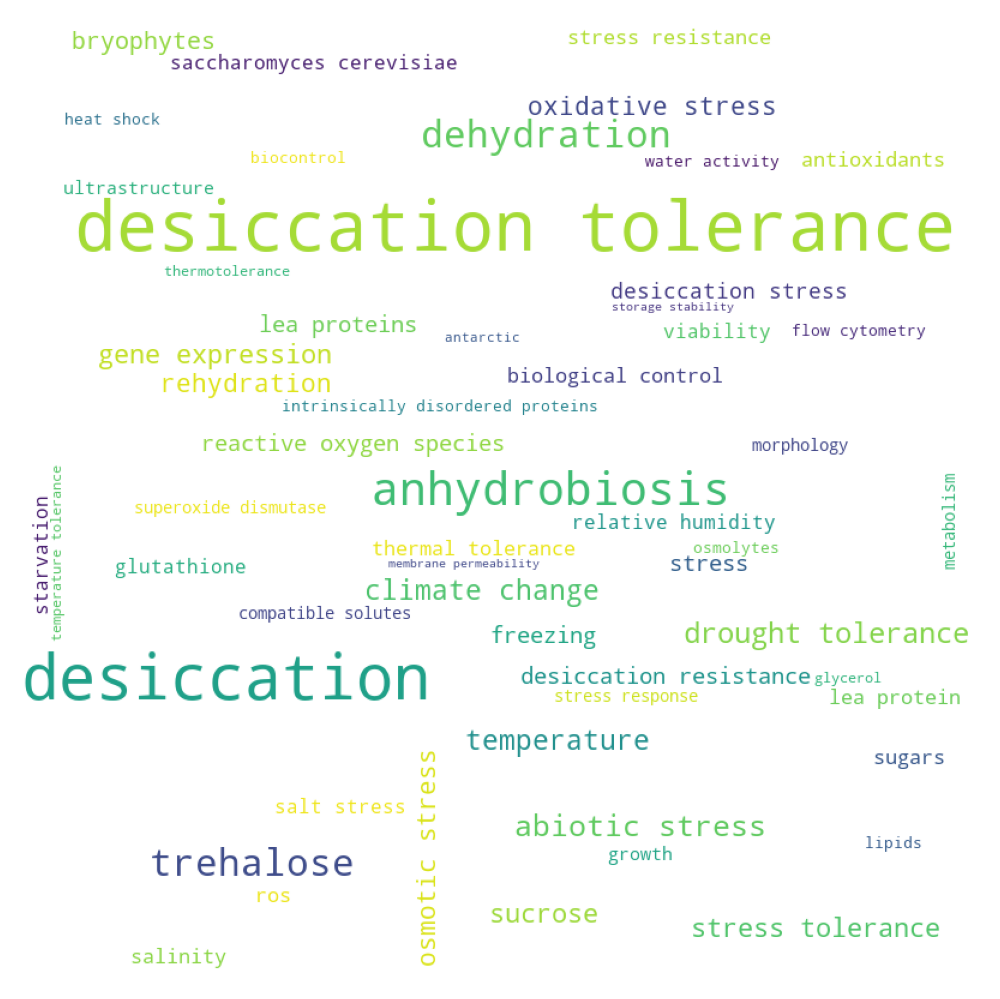

In [41]:
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('../data/citation_network/figures/shared_keywords_word_cloud.png', format='png', bbox_inches='tight', dpi=600)

## Build network

First, we'll build a network where the edges link keywords by citations. For simplicitly of visualization in both of the below graphs, we'll remove nodes that don't have edges. We'll also only look at the top 5% keywords by frequency.

In [61]:
all_keys = [k.lower() for doc in data for k in doc['paper_keywords']]
counted_all_keys = Counter(all_keys)
num_keywords = len(counted_all_keys)
percentage = 0.01
counted_top_keys = counted_all_keys.most_common(int(num_keywords*percentage))
to_keep_keys = [t[0] for t in counted_top_keys]
nodes = [(t[0], {'frequency': t[1]}) for t in counted_top_keys]

all_edges_weights = defaultdict(int)
for edge in graph.edges:
    p1_keys = paper_idx[edge[0]]
    p2_keys = paper_idx[edge[1]]
    for k1 in p1_keys:
        if k1 in to_keep_keys:
            for k2 in p2_keys:
                if k2 in to_keep_keys:
                    if k1 != k2:
                        all_edges_weights[(k1, k2)] += 1
# Combine reverse-ordered pair counts for edges
edges_joined_weights = defaultdict(int)
for pair, val in all_edges_weights.items():
    edges_joined_weights[tuple(set(pair))] += val
all_edges = [(c[0], c[1], {'weight': w}) for c, w in edges_joined_weights.items()]
            
keyword_graph = nx.Graph()
_ = keyword_graph.add_nodes_from(nodes)
_ = keyword_graph.add_edges_from(all_edges)

to_remove = [n for n, deg in keyword_graph.degree if deg == 0]
keyword_graph.remove_nodes_from(to_remove)

In [62]:
print(f'There are {len(keyword_graph.edges)} edges and {len(keyword_graph.nodes)} nodes in the citation keyword network.')

There are 5364 edges and 115 nodes in the citation keyword network.


In [63]:
nx.write_graphml(keyword_graph, '../data/citation_network/core_collection_destol_or_anhydro_FILTERED_keyword_network_29Jan2023_1_percent.graphml')

Now, let's build a keyword co-occurrence network -- this isn't related to citations, just about whether or not two keywords co-occur in the same paper.

In [50]:
all_keys = [k.lower() for doc in data for k in doc['paper_keywords']]
counted_all_keys = Counter(all_keys)
num_keywords = len(counted_all_keys)
percentage = 0.01
counted_top_keys = counted_all_keys.most_common(int(num_keywords*percentage))
to_keep_keys = [t[0] for t in counted_top_keys]
nodes = [(k, {'frequency': n}) for k, n in counted_top_keys]

all_edges_weights = defaultdict(int)
for doc in data:
    edges = combinations(doc['paper_keywords'], 2)
    edges = [e for e in edges if (e[0] in to_keep_keys) and (e[1] in to_keep_keys)]
    for pair in edges:
        if pair[0] != pair[1]:
            all_edges_weights[pair] += 1
# Combine reverse-ordered pair counts for edges
edges_joined_weights = defaultdict(int)
for pair, val in all_edges_weights.items():
    edges_joined_weights[tuple(set(pair))] += val
all_edges = [(c[0], c[1], {'weight': w}) for c, w in edges_joined_weights.items()]

keyword_graph = nx.Graph()
_ = keyword_graph.add_nodes_from(nodes)
_ = keyword_graph.add_edges_from(all_edges)

to_remove = [n for n, deg in keyword_graph.degree if deg == 0]
keyword_graph.remove_nodes_from(to_remove)

In [51]:
print(f'There are {len(keyword_graph.edges)} edges and {len(keyword_graph.nodes)} nodes in the keyword co-occurrence network.')

There are 1489 edges and 108 nodes in the keyword co-occurrence network.


In [52]:
nx.write_graphml(keyword_graph, '../data/citation_network/core_collection_destol_or_anhydro_FILTERED_keyword_co_occurrence_network_29Jan2023_1_percent.graphml')

## Keywords over time
I'd like to look at the frequency of the top 1% keywords in the literature over time, to see if there are any obvious trends. I'm going to exclude 2023 since we don't have a full year of papers.

In [34]:
all_keys = [k.lower() for doc in data for k in doc['paper_keywords']]
counted_all_keys = Counter(all_keys)
num_keywords = len(counted_all_keys)
percentage = 0.01
counted_top_keys = counted_all_keys.most_common(int(num_keywords*percentage))
to_keep_keys = [t[0] for t in counted_top_keys]

keyword_years = defaultdict(list)
for doc in data:
    year = int(doc['year'])
    if year == 2023:
        continue
    for keyword in doc['paper_keywords']:
        keyword_years[keyword.lower()].append(year)
keywords_per_year = {keyword: Counter(year_list) for keyword, year_list in keyword_years.items()}

2023
2023
2023


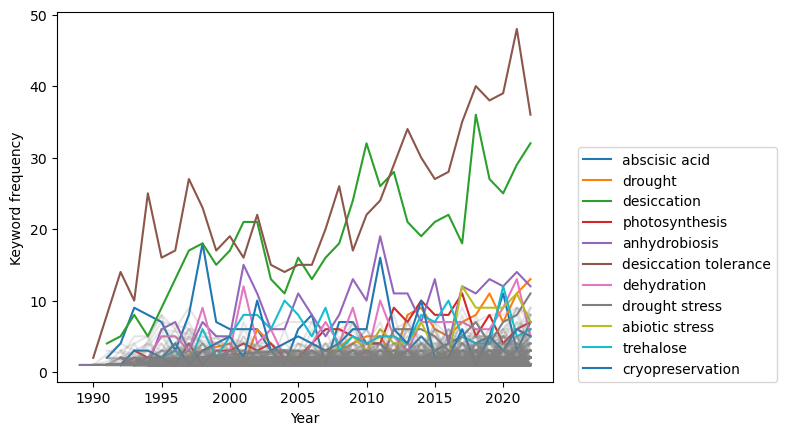

In [32]:
fig, ax = plt.subplots()

for keyword, year_dict in keywords_per_year.items():
    df = pd.DataFrame.from_dict(year_dict, orient='index', columns=['Count'])
    df = df.sort_index(axis='index')
    if df.Count.max() > 10:
        label = keyword
        plt.plot(df.index, df.Count, label=label)
    else:
        plt.plot(df.index, df.Count, label='_nolegend_', color='grey', alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Keyword frequency')
plt.legend(loc=(1.05, 0))

In [36]:
# Normalize by the number of papers per year
papers_per_year = defaultdict(int)
for doc in data:
    papers_per_year[int(doc['year'])] += 1
for keyword, year_dict in keywords_per_year.items():
    for year, num in year_dict.items():
        year_dict[year] = num/papers_per_year[year]

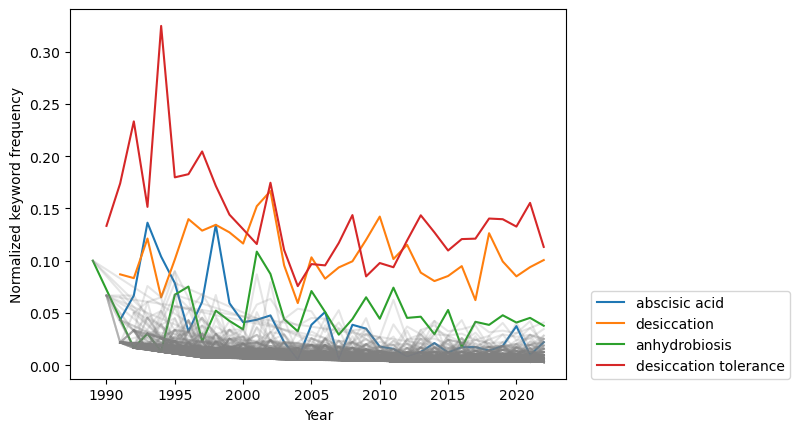

In [38]:
fig, ax = plt.subplots()

for keyword, year_dict in keywords_per_year.items():
    df = pd.DataFrame.from_dict(year_dict, orient='index', columns=['Count'])
    df = df.sort_index(axis='index')
    if df.Count.max() > 0.10:
        label = keyword
        plt.plot(df.index, df.Count, label=label)
    else:
        plt.plot(df.index, df.Count, label='_nolegend_', color='grey', alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Normalized keyword frequency')
plt.legend(loc=(1.05, 0))

Not all keywords appear in all years -- we can also track the introduction of new keywords over time.

In [39]:
first_appearance_years = {keyword: min(years.keys()) for keyword, years in keywords_per_year.items()}

In [43]:
firsts_per_year = defaultdict(list)
for keyword, year in first_appearance_years.items():
    firsts_per_year[year].append(keyword)
firsts_df = pd.DataFrame.from_dict({k: len(v) for k, v in firsts_per_year.items()}, orient='index', columns=['num_new_keywords']).sort_index()
firsts_df.head()

,num_new_keywords
1989,9
1990,21
1991,134
1992,155
1993,185


In [54]:
papers_year_df = pd.DataFrame.from_dict(papers_per_year, orient='index', columns=['num_papers'])
papers_and_keys = firsts_df.merge(papers_year_df, left_index=True, right_index=True)
papers_and_keys['normed_new_keywords'] = papers_and_keys['num_new_keywords']/papers_and_keys['num_papers']

In [55]:
papers_and_keys.head()

,num_new_keywords,normed_new_keywords,num_papers
1989,9,0.900000,10
1990,21,1.400000,15
1991,134,2.913043,46
1992,155,2.583333,60
1993,185,2.803030,66


Text(0, 0.5, 'Normalized count new keywords')

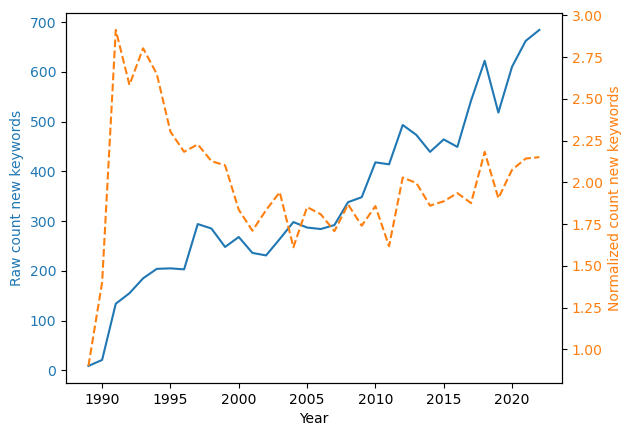

In [65]:
fig, ax = plt.subplots()

ax.plot(papers_and_keys.index, papers_and_keys.num_new_keywords, label='Raw count new keywords')
ax.set_ylabel('Raw count new keywords', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax.set_xlabel('Year')
lax = ax.twinx()
lax.tick_params(axis='y', labelcolor='tab:orange')
lax.plot(papers_and_keys.index, papers_and_keys.normed_new_keywords, label='Normalized count new keywords', linestyle='--', color='tab:orange')
lax.set_ylabel('Normalized count new keywords', color='tab:orange')